# Analyzing Unstructured Data

Version: January 2026

In this tutorial you will learn to:

* [web/screen scrape](https://en.wikipedia.org/wiki/Web_scraping) relatively unstructured data from the Wikipedia
* transform unstructured data into tabular data to facilitate processing with Python
* create graph data from your data to visualize your data as networks
* export Python-created data to use it with JavaScript visualization libraries such as [D3.js](https://d3js.org/)

Would you should already know:

* a little Python 3
* some minor HTML
* some JavaScript if you want to understand the web-based visualization at the end of the tutorial

This notebook assumes that you are using [Anaconda](https://www.anaconda.com/download/) as your Python 3 distribution.

## Preparing Your Environment

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from bs4 import BeautifulSoup
from collections import OrderedDict # provides the ordered dictionary
import re # for regular expressions used below
import urllib # to read from URLs
import networkx as nx # network analysis
import itertools
from datetime import datetime # for time measurement
import sys
import os
import unicodedata as ucd

# utility method that displays a given text and the current time
def printLog(text):
    now=str(datetime.now())
    print("["+now+"]\t"+text)
    # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print
    sys.stdout.flush()

This notebook can be used to work with superheroes of the DC Comics or Marvel universe. However, only one universe can be processed at once.

In [2]:
isMarvel=True

if isMarvel:
    # Marvel
    imageDownloadPath="./web/force/img.marvel_chars/"
    localRelativeImagePath="img.marvel_chars/"
    csvFilePath="marvel_superheroes.csv"
    pathPrefix="marvel"
    printLog("Analysing Marvel universe...")
else:
    # DC Comics
    imageDownloadPath="./web/force/img.dc_chars/"
    localRelativeImagePath="img.dc_chars/"
    csvFilePath="dc_superheroes.csv"
    pathPrefix="dc"
    printLog("Analysing DC universe...")

# if the needed paths do not exist, create them
if not os.path.exists(imageDownloadPath):
    os.mkdir(imageDownloadPath)

[2026-01-20 13:27:20.499936]	Analysing Marvel universe...


## Screen-Scraping
Anaconda comes with _Beautiful Soup_, a library for screen-scraping [documentation](http://www.crummy.com/software/BeautifulSoup/bs4/doc/). The main idea is to download a HTML page from the Wikipedia, parse its contents, and save it in a structed way. This functionality is encapsulated in the function _extractData()_ (see below).

The relevant data is hidden in a table with the CSS class _infobox_. The _th_ tags serve as separators for the following information:
* <th scope="row" style="width: 40%;">Alter ego</th>
* <th scope="row" style="width: 40%;">Team affiliations</th>
* <th scope="row" style="width: 40%;">Partnerships</th>
* <th scope="row" style="width: 40%;">Notable aliases</th>
* <th scope="row" style="width: 40%;">Abilities</th>

The function also relies on [_regular expressions_](https://docs.python.org/2/howto/regex.html) - if you haven't heard of them before...

In [4]:
def extractData(myDoc): # myDoc is the HTML document to be parsed
    # initialize the screen-scraper
    soup = BeautifulSoup(myDoc, 'html.parser')
    # during an inspection of the Wikipedia HTML, we discovered that table elements with the CSS class infobox have to be parsed
    tables=soup.find_all('table',class_="infobox")
    # if there is no infobox, ignore the page
    if len(tables)>=1:
        # take the first infobox
        infoboxTable=tables[0]
        # try to get the name of the character
        if infoboxTable.tr.th is not None:
            name=infoboxTable.tr.th.get_text()
        else:
            #if it is not part of the infobox take it from the HTML page's title and strip the Wikipedia reference
            name=soup.title.get_text().replace(" - Wikipedia, the free encyclopedia","")
        # prepare variables for the data to be extracted
        abilityRow=None
        partnerRow=None
        firstAppearance="2020" # dummy entry in case the "first appearance" entry is missing
        abilities=[]
        partnerships=[]
        
        # save the provided image for later processing
        if infoboxTable.find('img'):
            articleImage=infoboxTable.find('img')["src"]
        else:
            articleImage=None

        p = re.compile(r'\d\d\d\d') # we expect the year of first appearance to have four digits
        
        rows=infoboxTable.find_all("tr")
        for row in rows:
            if row.th is not None and row.th.string == "First appearance":
                rawText=row.td.get_text()
                m = p.search(rawText)
                # deal with missing years of first appearance
                if m:
                    firstAppearance=m.group()
            elif row.th is not None and row.th.string == "Abilities":
                abilityRow=row
            elif row.th is not None and row.th.string == "Partnerships":
                partnerRow=row

        # as not every page has a "complete" infobox, we have to check the presence of abilities and partnerships
        if abilityRow is not None:
            li=abilityRow.find_all("li")
            for l in li:
                # check if an anchor (a link to a website) is contained
                if l.a is not None:
                    # if so, discard the link and keep the plain text
                    l.a.unwrap()
                abilities.append(l.get_text().strip())
        # a fix for abilities without the ul/li structure
            if len(li)==0:
                rawStr=str(abilityRow.td)
                rawStr=rawStr.replace("<td>","").replace("</td>","").replace("\n","").strip()
                # abilities are sometimes separated by  <br/>, a comma, a period, or "and"
                rawStr=rawStr.replace("<br/>",";")
                rawStr=rawStr.replace(",",";")
                rawStr=rawStr.replace(".",";")
                # we have to treat 'and' in a special way as it may be contained as a substring in "normal" words
                #rawStr=rawStr.replace("and",";")
                rawTokens=rawStr.split(" and ")
                rawStr=";".join(rawTokens)
                # remove all other HTML tags
                p2 = re.compile(r'<.*?>')
                rawStr=p2.sub(' ', rawStr)
                # clean whitespaces surrounding the string
                rawStr.strip()
                rawTokens=rawStr.split(";")
                for t in rawTokens:
                    t=t.strip()
                    # we have to ignore additional noise such as the following "abilities"
                    if t.lower()=="see below":
                        pass
                    elif t.lower()=="various":
                        pass
                    elif t.lower()=="varies":
                        pass
                    elif t.lower()=="none":
                        pass
                    else:
                        if str(t):
                            abilities.append(str(t))

        if partnerRow is not None:
            partners=partnerRow.find_all("a")
            for p in partners:
                if p.string is not None: # some Marvel pages "suffer" from empty <a>
                    partnerships.append(p.string)

        
        
        result=dict()
        result["name"]=name
        result["firstAppearance"]=int(firstAppearance)
        result["abilities"]=abilities
        result["abilitiesCount"]=len(abilities)
        result["partnerships"]=partnerships
        result["partnershipsCount"]=len(partnerships)
        if articleImage:
            result["imageURL"]="https:"+str(articleImage)
        else:
            result["imageURL"]="https://None"
        #print abilities
        return result
    else:
        return None

### Testing the Function
In order to find out whether the function works, we call it with two superheroes.

In [11]:
# set a user agent manually (2026)
url="https://en.wikipedia.org/wiki/Juggernaut_(comics)"
req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
html_doc = urllib.request.urlopen(req).read()

r=extractData(html_doc)
print(r)

print("\n NEXT SUPERHERO\n")

url="https://en.wikipedia.org/wiki/Batman"
req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
html_doc = urllib.request.urlopen(req).read()
r=extractData(html_doc)
print(r)

{'name': 'Juggernaut', 'firstAppearance': 1965, 'abilities': ['Superhuman strength, stamina, and durability', 'Unstoppable momentum', 'Immortality', 'Psychic shield via helmet'], 'abilitiesCount': 4, 'partnerships': ['Black Tom Cassidy', 'ForgetMeNot'], 'partnershipsCount': 2, 'imageURL': 'https://upload.wikimedia.org/wikipedia/en/thumb/4/44/Juggernaut2.PNG/250px-Juggernaut2.PNG'}

 NEXT SUPERHERO

{'name': 'Batman', 'firstAppearance': 1939, 'abilities': ['Genius-level intellect', 'Expert detective', 'Master martial artist and hand-to-hand combatant', 'Master tactician, strategist and field commander', 'Proficient in using high-tech equipment and weapons'], 'abilitiesCount': 5, 'partnerships': ['Robin', 'Batgirl', 'Alfred Pennyworth', 'James Gordon', 'Superman', 'Wonder Woman', 'Catwoman'], 'partnershipsCount': 7, 'imageURL': 'https://upload.wikimedia.org/wikipedia/en/c/c7/Batman_Infobox.jpg'}


However, the reality is more complex but the Wikipedia provides lists of superheroes of the different universes.

In [13]:
categoryPages=[]
if not isMarvel:
    # DC superheroes
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pageuntil=Dragon+King%0ADragon+King+%28DC+Comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=Krypto#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=Robin%0ARobin+%28comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=XS+%28comics%29#mw-pages")
    # general DC characters
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_characters&pageuntil=Smoak%2C+Felicity%0AFelicity+Smoak#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_characters&pagefrom=Smoak%2C+Felicity%0AFelicity+Smoak#mw-pages")
else:
    # Marvel superheroes
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pageuntil=Dazzler#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Dazzler#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Jameson%0AJohn+Jameson+%28comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Prime+%28Comics%29%0APrime+%28comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Talon+%28Marvel+Comics%29#mw-pages")

The following function expects Wikipedia category pages as provided above and retrieves the URLs of relevant superhero Wikipedia articles.

In [14]:
def getSuperheroes(myCategories,myDictionary):
    for c in myCategories:
    # ignore <a class="mw-redirect"> as they redirect into articles, 
    # to be precise, we only consider <a> tags without a class atrribute 
    # because we are only interested in superheroes with distinct wikipedia articles
        items=c.ul.find_all("li")
        for item in items:
            if item.a.get("class") is None:
                myDictionary[item.a["title"]]=item.a["href"]


startTime=datetime.now()
printLog("Fetching superhero URLs...")

superheroes=OrderedDict() # we use an ordered dict here because we want to preserve the order items were added
for catPage in categoryPages:
    req = urllib.request.Request(catPage, headers={'User-Agent': 'Mozilla/5.0'})
    html_doc = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(html_doc, 'html.parser')
    categories=soup.select("#mw-pages")[0].select(".mw-category-group")
    getSuperheroes(categories,superheroes) # we pass the superheroes dictionary on to merge the heroes extracted from all pages

duration=datetime.now()-startTime
printLog("Processing completed in "+str(duration)+".")

[2026-01-20 13:39:26.124655]	Fetching superhero URLs...
[2026-01-20 13:39:29.275763]	Processing completed in 0:00:03.151070.


Given a list of URLs, we can extract the data for each superhero.

In [16]:
wikiBaseURL="https://en.wikipedia.org"
heroFeats=[]
i=0;
countItems=len(superheroes)

printLog("Processing "+str(countItems)+" Wikipedia pages. This will take a while...")

startTime=datetime.now()


for key, value in superheroes.items():
    i=i+1
    wikiURL=wikiBaseURL+value
    #print "Processing "+wikiURL+" ; "+str(i)+" of "+str(countItems)
    req = urllib.request.Request(wikiURL, headers={'User-Agent': 'Mozilla/5.0'})
    html_doc = urllib.request.urlopen(req).read()
    r=extractData(html_doc)
    if r:
        r["url"]=wikiURL
        heroFeats.append(r)
    else:
        print("\t"+wikiURL+" does not contain an infobox. Processing aborted.")

duration=datetime.now()-startTime
printLog("Processing completed in "+str(duration)+".")

[2026-01-20 13:40:32.048999]	Processing 331 Wikipedia pages. This will take a while...
	https://en.wikipedia.org/wiki/Hawkeye_(comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Red_Hulk does not contain an infobox. Processing aborted.
[2026-01-20 13:43:21.401777]	Processing completed in 0:02:49.351811.


Additionally, we will download the character images if there are some.

In [24]:
printLog("Downloading images. This will take a while...")

# Python 3 relate urlretrieve() deprecation fix
def urlretrieve(url, data):
    req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    url_data = urllib.request.urlopen(req)
    with open(data, "wb") as local_file:
        local_file.write(url_data.read())

startTime=datetime.now()
# downloading images

if not os.path.exists(imageDownloadPath):
    os.makedirs(imageDownloadPath)

for i,hero in enumerate(heroFeats):
    hero["localFilePath"]="N/A" # caveat of JSON http://stackoverflow.com/questions/13715891/d3-json-uncaught-typeerror-cannot-read-property-children-of-undefined
    iURL=hero["imageURL"]
    if not iURL=="https://None":
        tokens=iURL.split(".")
        suffix=tokens[-1]
        localFilePath=imageDownloadPath+str(i)+"."+suffix
        # debug
        #print("Downloading to: "+localFilePath)
        hero["localFilePath"]=localRelativeImagePath+str(i)+"."+suffix
        try:
            urlretrieve(iURL,localFilePath)
            #urllib.request.urlretrieve(iURL,localFilePath)
        except IOError as err: # if we would catch all other exception, we would have a hard time to stop the kernel at all
            print("Downloading error while accessing: "+hero["imageURL"]+ " and/or saving in: "+localFilePath)
            print(f"\tReason: {err}")
            #break
duration=datetime.now()-startTime
printLog("Downloading completed in "+str(duration)+".")

[2026-01-20 13:58:58.192444]	Downloading images. This will take a while...
	Reason: HTTP Error 429: Use thumbnail steps listed on https://w.wiki/GHai. Please contact noc@wikimedia.org for further information (a765913)
	Reason: HTTP Error 429: Your request is invalid. Please contact noc@wikimedia.org for further information (0fa5166)
	Reason: HTTP Error 429: Your request is invalid. Please contact noc@wikimedia.org for further information (0fa5166)
	Reason: HTTP Error 429: Your request is invalid. Please contact noc@wikimedia.org for further information (0fa5166)
	Reason: HTTP Error 429: Your request is invalid. Please contact noc@wikimedia.org for further information (0fa5166)
	Reason: HTTP Error 429: Your request is invalid. Please contact noc@wikimedia.org for further information (0fa5166)
	Reason: HTTP Error 429: Your request is invalid. Please contact noc@wikimedia.org for further information (0fa5166)
	Reason: HTTP Error 429: Your request is invalid. Please contact noc@wikimedia.o

## Converting the Raw Data into Tables

For further processing relying on Python's typical data science libraries, it is handy to save the data in a Pandas [DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html), a tabular data structure with built-in support for various analytical tasks.

In [25]:
rows=[]
columns=["Name","Year","Decade","Abilities","AbilitiesCount","Partnerships","PartnershipsCount","URL","ImageURL","localFilePath"]

# take each hero and save attributes in a data frame
for hero in heroFeats:
    #print(hero["name"])
    rowx=[]
    rowx.append(hero["name"])
    firstAp=hero["firstAppearance"]
    rowx.append(firstAp)
    # calculate the decade
    if firstAp<2000:
        rowx.append(1900+int((hero["firstAppearance"]-1900)/10)*10)
    else:
        rowx.append(2000+int((hero["firstAppearance"]-2000)/10)*10)
    rowx.append(",".join(hero["abilities"]))
    rowx.append(hero["abilitiesCount"])
    rowx.append(",".join(hero["partnerships"]))
    rowx.append(hero["partnershipsCount"])
    rowx.append(hero["url"])
    rowx.append(hero["imageURL"])
    rowx.append(hero["localFilePath"])
    rows.append(rowx)

df=pd.DataFrame(rows,columns=columns)
df.head() # display the top rows of the data frame

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath
0,Abomination,1967,1960,"Superhuman strength, stamina, durability, spee...",4,Leader,1,https://en.wikipedia.org/wiki/Abomination_(cha...,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/0.png
1,Agent X,2002,2000,"Superhuman strength, stamina, agility, speed, ...",6,,0,https://en.wikipedia.org/wiki/Agent_X_(Marvel_...,https://upload.wikimedia.org/wikipedia/en/a/a9...,img.marvel_chars/1.jpg
2,Gabriel LanAir-Walker,1972,1970,Power Cosmic,1,,0,https://en.wikipedia.org/wiki/Air-Walker,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/2.jpg
3,Ajak,1976,1970,"Superhuman speed, strength, and durability,Cos...",7,,0,https://en.wikipedia.org/wiki/Ajak,https://None,N/A
4,Anole,2003,2000,"Green scaly skin,,Spiked head carapace,,Prehen...",7,,0,https://en.wikipedia.org/wiki/Anole_(character),https://upload.wikimedia.org/wikipedia/en/5/56...,img.marvel_chars/4.jpg


Unfortunately, the table is not ready for processing. For instance, the superheroe's name are using lower and upper case letters which would complicate later comparisons. There are also encoding issues. Hence, we normalize textual date before we continue with the analysis.

To simplify the code, we rely on [lambda functions](https://www.w3schools.com/python/python_lambda.asp), anonymous functions that get applied on most attributes of the data frame. In order to be non-destructive, we save the results in separate columns.

In [26]:
# to avoid spelling issues, we capitalize all superheroes' names
# lambda Konzept erläutern
try:
    df['NameCaps'] = df.Name.apply(lambda x: x.upper())
except(UnicodeEncodeError):
    df['NameCaps'] = df.Name.apply(lambda x: ucd.normalize('NFKD', unicode(x)).encode('ascii','ignore').upper())
#    utf8str=row[13].decode('utf-8')
#    str2=ucd.normalize('NFKD', utf8str).encode('ascii','ignore')
try:
    df['PartnershipsCaps'] = df.Partnerships.astype(str).apply(lambda x: x.upper())
except(UnicodeEncodeError):
    df['PartnershipsCaps'] = df.Partnerships.apply(lambda x: ucd.normalize('NFKD', unicode(x)).encode('ascii','ignore').upper())
try:
    df['AbilitiesCaps'] = df.Abilities.astype(str).apply(lambda x: x.upper())
except(UnicodeEncodeError):
    df['AbilitiesCaps'] = df.Abilities.apply(lambda x: ucd.normalize('NFKD', unicode(x)).encode('ascii','ignore').upper())
df.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abomination,1967,1960,"Superhuman strength, stamina, durability, spee...",4,Leader,1,https://en.wikipedia.org/wiki/Abomination_(cha...,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/0.png,ABOMINATION,LEADER,"SUPERHUMAN STRENGTH, STAMINA, DURABILITY, SPEE..."
1,Agent X,2002,2000,"Superhuman strength, stamina, agility, speed, ...",6,,0,https://en.wikipedia.org/wiki/Agent_X_(Marvel_...,https://upload.wikimedia.org/wikipedia/en/a/a9...,img.marvel_chars/1.jpg,AGENT X,,"SUPERHUMAN STRENGTH, STAMINA, AGILITY, SPEED, ..."
2,Gabriel LanAir-Walker,1972,1970,Power Cosmic,1,,0,https://en.wikipedia.org/wiki/Air-Walker,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/2.jpg,GABRIEL LANAIR-WALKER,,POWER COSMIC
3,Ajak,1976,1970,"Superhuman speed, strength, and durability,Cos...",7,,0,https://en.wikipedia.org/wiki/Ajak,https://None,N/A,AJAK,,"SUPERHUMAN SPEED, STRENGTH, AND DURABILITY,COS..."
4,Anole,2003,2000,"Green scaly skin,,Spiked head carapace,,Prehen...",7,,0,https://en.wikipedia.org/wiki/Anole_(character),https://upload.wikimedia.org/wikipedia/en/5/56...,img.marvel_chars/4.jpg,ANOLE,,"GREEN SCALY SKIN,,SPIKED HEAD CARAPACE,,PREHEN..."


Finally, we save the results as a CSV file. However, Excel, a database, or many more other formats would also be possible. This is also a good place to take a rest and continue later on.

In [27]:
# save to file without the index columns of the data frame and separate each field with a tabstop
df.to_csv(csvFilePath,index=False,header=True,encoding='utf-8', sep="\t")

## Continuing the Analysis
If you have shutdown the notebook before, you can read in the data again with [read_csv()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html).

In [28]:
df=pd.read_csv(csvFilePath,encoding='utf-8', sep="\t",dtype={"Partnerships":'str'})
df.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abomination,1967,1960,"Superhuman strength, stamina, durability, spee...",4,Leader,1,https://en.wikipedia.org/wiki/Abomination_(cha...,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/0.png,ABOMINATION,LEADER,"SUPERHUMAN STRENGTH, STAMINA, DURABILITY, SPEE..."
1,Agent X,2002,2000,"Superhuman strength, stamina, agility, speed, ...",6,NaN,0,https://en.wikipedia.org/wiki/Agent_X_(Marvel_...,https://upload.wikimedia.org/wikipedia/en/a/a9...,img.marvel_chars/1.jpg,AGENT X,NaN,"SUPERHUMAN STRENGTH, STAMINA, AGILITY, SPEED, ..."
2,Gabriel LanAir-Walker,1972,1970,Power Cosmic,1,NaN,0,https://en.wikipedia.org/wiki/Air-Walker,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/2.jpg,GABRIEL LANAIR-WALKER,NaN,POWER COSMIC
3,Ajak,1976,1970,"Superhuman speed, strength, and durability,Cos...",7,NaN,0,https://en.wikipedia.org/wiki/Ajak,https://None,NaN,AJAK,NaN,"SUPERHUMAN SPEED, STRENGTH, AND DURABILITY,COS..."
4,Anole,2003,2000,"Green scaly skin,,Spiked head carapace,,Prehen...",7,NaN,0,https://en.wikipedia.org/wiki/Anole_(character),https://upload.wikimedia.org/wikipedia/en/5/56...,img.marvel_chars/4.jpg,ANOLE,NaN,"GREEN SCALY SKIN,,SPIKED HEAD CARAPACE,,PREHEN..."


Next, we will test wheter all superhero names are unique - a valid hypothesis...

In [29]:
countNames=df.NameCaps.count()
uniqueNames=len(df.NameCaps.unique())

print("Total number of names: %d, Unique number of names: %d" % (countNames,uniqueNames))
if countNames!=uniqueNames:
    print("Attention! Names are not unique.")

Total number of names: 329, Unique number of names: 323
Attention! Names are not unique.


Unfortunately, the names are not unique.
To drop the duplicates, we apply a rather simple strategy: we keep the oldest, i.e., the first appearing, superheroes using pandas utility function [drop_duplicates()](http://pandas.pydata.org/pandas-docs/version/0.17.1/generated/pandas.DataFrame.drop_duplicates.html).

In [30]:
df.drop_duplicates(subset='NameCaps',keep='first',inplace=True)

countNames=df.NameCaps.count()
uniqueNames=len(df.NameCaps.unique())

print("Total number of names: %d, Unique number of names: %d" % (countNames,uniqueNames))
if countNames!=uniqueNames:
    print("Attention! Names are not unique.")

Total number of names: 323, Unique number of names: 323


After we made sure that every superhero appears only once, we will try to find out if there are "lone wolf" characters. These heros are copied into a new data frame.
Further selections are made for demonstration purposes...

In [31]:
# the "lonely" superheroes are created from the original data frame selecting each row where the column "Partnerships" is Null (not set)
df2=df[df["Partnerships"].isnull()]
df2.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
1,Agent X,2002,2000,"Superhuman strength, stamina, agility, speed, ...",6,NaN,0,https://en.wikipedia.org/wiki/Agent_X_(Marvel_...,https://upload.wikimedia.org/wikipedia/en/a/a9...,img.marvel_chars/1.jpg,AGENT X,NaN,"SUPERHUMAN STRENGTH, STAMINA, AGILITY, SPEED, ..."
2,Gabriel LanAir-Walker,1972,1970,Power Cosmic,1,NaN,0,https://en.wikipedia.org/wiki/Air-Walker,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/2.jpg,GABRIEL LANAIR-WALKER,NaN,POWER COSMIC
3,Ajak,1976,1970,"Superhuman speed, strength, and durability,Cos...",7,NaN,0,https://en.wikipedia.org/wiki/Ajak,https://None,NaN,AJAK,NaN,"SUPERHUMAN SPEED, STRENGTH, AND DURABILITY,COS..."
4,Anole,2003,2000,"Green scaly skin,,Spiked head carapace,,Prehen...",7,NaN,0,https://en.wikipedia.org/wiki/Anole_(character),https://upload.wikimedia.org/wikipedia/en/5/56...,img.marvel_chars/4.jpg,ANOLE,NaN,"GREEN SCALY SKIN,,SPIKED HEAD CARAPACE,,PREHEN..."
5,Anti-Venom,2008,2000,All powers of the Venom symbiote's first human...,6,NaN,0,https://en.wikipedia.org/wiki/Anti-Venom,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/5.png,ANTI-VENOM,NaN,ALL POWERS OF THE VENOM SYMBIOTE'S FIRST HUMAN...


In [32]:
# the "sociable" superheroes
df3=df[df["Partnerships"].notnull()]
df3.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abomination,1967,1960,"Superhuman strength, stamina, durability, spee...",4,Leader,1,https://en.wikipedia.org/wiki/Abomination_(cha...,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/0.png,ABOMINATION,LEADER,"SUPERHUMAN STRENGTH, STAMINA, DURABILITY, SPEE..."
7,Anya CorazonAraña,2004,2000,"Superhuman strength, speed, agility, stamina, ...",4,"Ms. Marvel,Spider-Man,Spider-Woman",3,https://en.wikipedia.org/wiki/Anya_Corazon,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/7.jpg,ANYA CORAZONARAÑA,"MS. MARVEL,SPIDER-MAN,SPIDER-WOMAN","SUPERHUMAN STRENGTH, SPEED, AGILITY, STAMINA, ..."
12,Rikki Barnes,1996,1990,"Inter-reality reincarnation,Master martial art...",2,Captain America,1,https://en.wikipedia.org/wiki/Rikki_Barnes,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/12.jpg,RIKKI BARNES,CAPTAIN AMERICA,"INTER-REALITY REINCARNATION,MASTER MARTIAL ART..."
13,Battlestar,1986,1980,"Superhuman strength, agility, stamina, durabil...",5,U.S. Agent,1,https://en.wikipedia.org/wiki/Battlestar_(char...,https://upload.wikimedia.org/wikipedia/en/7/78...,img.marvel_chars/13.png,BATTLESTAR,U.S. AGENT,"SUPERHUMAN STRENGTH, AGILITY, STAMINA, DURABIL..."
15,Baymax,1998,1990,Morph body into dragon or mecha,1,Hiro Takachiho,1,https://en.wikipedia.org/wiki/Baymax,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/15.jpg,BAYMAX,HIRO TAKACHIHO,MORPH BODY INTO DRAGON OR MECHA


In [33]:
# the oldest superhero(ine)
df[df['Year']==df['Year'].min()]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
45,Breeze Barton,1940,1940,"Exceptional hand-to-hand combatant,Experienced...",7,NaN,0,https://en.wikipedia.org/wiki/Breeze_Barton,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/45.jpg,BREEZE BARTON,NaN,"EXCEPTIONAL HAND-TO-HAND COMBATANT,EXPERIENCED..."
173,Makkari,1940,1940,"Superhuman strength, speed, durability, and st...",7,NaN,0,https://en.wikipedia.org/wiki/Makkari_(character),https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/173.jpg,MAKKARI,NaN,"SUPERHUMAN STRENGTH, SPEED, DURABILITY, AND ST..."
216,Red Raven,1940,1940,"Flight using mechanical wings,Access to alien ...",3,NaN,0,https://en.wikipedia.org/wiki/Red_Raven_(Marve...,https://None,NaN,RED RAVEN,NaN,"FLIGHT USING MECHANICAL WINGS,ACCESS TO ALIEN ..."
288,Thena,1940,1940,"Superhuman strength, stamina, durability, spee...",8,NaN,0,https://en.wikipedia.org/wiki/Thena,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/288.jpg,THENA,NaN,"SUPERHUMAN STRENGTH, STAMINA, DURABILITY, SPEE..."
289,Thin Man,1940,1940,"Accomplished airplane pilot,Elasticity,Shapesh...",9,NaN,0,https://en.wikipedia.org/wiki/Thin_Man_(charac...,https://None,NaN,THIN MAN,NaN,"ACCOMPLISHED AIRPLANE PILOT,ELASTICITY,SHAPESH..."
295,Toro,1940,1940,"Fire manipulation,resistance,Flight",3,Human Torch,1,https://en.wikipedia.org/wiki/Toro_(character),https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/295.jpg,TORO,HUMAN TORCH,"FIRE MANIPULATION,RESISTANCE,FLIGHT"


In [34]:
# get the superhero with the maximal number of abilities
df[df['AbilitiesCount']==df['AbilitiesCount'].max()]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
265,Peter ParkerSpider-Man Noir,2009,2000,"mw-parser-output,hlist dl,mw-parser-output,hli...",115,NaN,0,https://en.wikipedia.org/wiki/Spider-Man_Noir,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/265.png,PETER PARKERSPIDER-MAN NOIR,NaN,"MW-PARSER-OUTPUT,HLIST DL,MW-PARSER-OUTPUT,HLI..."


In [35]:
# select superheroes that first appeared during 1939 and 1945
df[(df.Year>=1939) & (df.Year<1945)]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
26,Black Marvel,1941,1940,"Excellent hand to hand combatant,Peak physical...",2,NaN,0,https://en.wikipedia.org/wiki/Black_Marvel,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/26.jpg,BLACK MARVEL,NaN,"EXCELLENT HAND TO HAND COMBATANT,PEAK PHYSICAL..."
33,Blazing Skull,1941,1940,"Superhuman strength,Immunity to fire,Regenerat...",6,NaN,0,https://en.wikipedia.org/wiki/Blazing_Skull,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/33.jpg,BLAZING SKULL,NaN,"SUPERHUMAN STRENGTH,IMMUNITY TO FIRE,REGENERAT..."
38,The Blue Diamond,1941,1940,"Superhuman strength,Nigh-invulnerability,Diamo...",6,NaN,0,https://en.wikipedia.org/wiki/Blue_Diamond_(ch...,https://upload.wikimedia.org/wikipedia/en/9/92...,img.marvel_chars/38.jpg,THE BLUE DIAMOND,NaN,"SUPERHUMAN STRENGTH,NIGH-INVULNERABILITY,DIAMO..."
45,Breeze Barton,1940,1940,"Exceptional hand-to-hand combatant,Experienced...",7,NaN,0,https://en.wikipedia.org/wiki/Breeze_Barton,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/45.jpg,BREEZE BARTON,NaN,"EXCEPTIONAL HAND-TO-HAND COMBATANT,EXPERIENCED..."
48,Bucky,1941,1940,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Bucky_(Marvel_Co...,https://None,NaN,BUCKY,NaN,NaN
66,Citizen V,1942,1940,"Master hand-to-hand combatant, martial artist,...",2,NaN,0,https://en.wikipedia.org/wiki/Citizen_V,https://upload.wikimedia.org/wikipedia/en/e/e9...,img.marvel_chars/66.jpg,CITIZEN V,NaN,"MASTER HAND-TO-HAND COMBATANT, MARTIAL ARTIST,..."
83,Doctor Nemesis,1941,1940,"Accomplished investigator,hand to hand combata...",6,NaN,0,https://en.wikipedia.org/wiki/Doctor_Nemesis,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/83.jpg,DOCTOR NEMESIS,NaN,"ACCOMPLISHED INVESTIGATOR,HAND TO HAND COMBATA..."
93,Father Time,1941,1940,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Father_Time_(Mar...,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/93.jpg,FATHER TIME,NaN,NaN
122,Hercules,1943,1940,"Superhuman agility, durability, endurance, sta...",4,Amadeus Cho,1,https://en.wikipedia.org/wiki/Hercules_(Marvel...,https://upload.wikimedia.org/wikipedia/en/a/ab...,img.marvel_chars/122.png,HERCULES,AMADEUS CHO,"SUPERHUMAN AGILITY, DURABILITY, ENDURANCE, STA..."
143,Jack Frost,1941,1940,"Cold,ice manipulation,Superhuman stamina,durab...",4,NaN,0,https://en.wikipedia.org/wiki/Jack_Frost_(Marv...,https://upload.wikimedia.org/wikipedia/en/6/65...,img.marvel_chars/143.jpg,JACK FROST,NaN,"COLD,ICE MANIPULATION,SUPERHUMAN STAMINA,DURAB..."


In [36]:
# the not so gifted superheroes with only one ability
df[df['AbilitiesCount']==1]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
2,Gabriel LanAir-Walker,1972,1970,Power Cosmic,1,NaN,0,https://en.wikipedia.org/wiki/Air-Walker,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/2.jpg,GABRIEL LANAIR-WALKER,NaN,POWER COSMIC
15,Baymax,1998,1990,Morph body into dragon or mecha,1,Hiro Takachiho,1,https://en.wikipedia.org/wiki/Baymax,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/15.jpg,BAYMAX,HIRO TAKACHIHO,MORPH BODY INTO DRAGON OR MECHA
20,Bird-Brain,1987,1980,Flight,1,NaN,0,https://en.wikipedia.org/wiki/Bird-Brain_(Marv...,https://upload.wikimedia.org/wikipedia/en/a/ad...,img.marvel_chars/20.png,BIRD-BRAIN,NaN,FLIGHT
39,Blue Eagle,1971,1970,Powers of flight derived from the special wing...,1,NaN,0,https://en.wikipedia.org/wiki/Blue_Eagle_(char...,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/39.jpg,BLUE EAGLE,NaN,POWERS OF FLIGHT DERIVED FROM THE SPECIAL WING...
62,Sara (last name unknown),2008,2000,Teleportation,1,NaN,0,https://en.wikipedia.org/wiki/Caretaker_(comics),https://None,NaN,SARA (LAST NAME UNKNOWN),NaN,TELEPORTATION
76,Emrys Killebrew,1994,1990,Expert scientist,1,NaN,0,https://en.wikipedia.org/wiki/Emrys_Killebrew,https://upload.wikimedia.org/wikipedia/en/9/9e...,img.marvel_chars/76.png,EMRYS KILLEBREW,NaN,EXPERT SCIENTIST
78,Debrii,2005,2000,Telekinesis,1,NaN,0,https://en.wikipedia.org/wiki/Debrii,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/78.jpg,DEBRII,NaN,TELEKINESIS
89,Fabio Medina,2013,2010,Ability to project non-viable golden ball-shap...,1,NaN,0,https://en.wikipedia.org/wiki/Fabio_Medina,https://upload.wikimedia.org/wikipedia/en/d/d2...,img.marvel_chars/89.png,FABIO MEDINA,NaN,ABILITY TO PROJECT NON-VIABLE GOLDEN BALL-SHAP...
90,Manuel de la RochaEmpath,1984,1980,Psionic ability to sense and control emotions ...,1,NaN,0,https://en.wikipedia.org/wiki/Empath_(character),https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/90.jpg,MANUEL DE LA ROCHAEMPATH,NaN,PSIONIC ABILITY TO SENSE AND CONTROL EMOTIONS ...
119,Helix,1995,1990,Reactive adaptation,1,NaN,0,https://en.wikipedia.org/wiki/Helix_(Marvel_Co...,https://upload.wikimedia.org/wikipedia/en/thum...,img.marvel_chars/119.png,HELIX,NaN,REACTIVE ADAPTATION


After inspecting the last selection, we see that the abilities column is not in [first normal form](https://en.wikipedia.org/wiki/First_normal_form) and the abilities count is not correct for every superhero. Hence, we should consider to split the abilities column and update abilitiesCount accordingly.

### Statistics
If we want to get a general "feeling" about our data frame, the _describe()_ method becomes handy as it computes various statstics for you.

In [37]:
df.describe()

,Year,Decade,AbilitiesCount,PartnershipsCount
count,323.000000,323.000000,323.000000,323.000000
mean,1983.551084,1979.411765,5.099071,0.421053
std,23.213558,22.949325,7.443541,1.055504
min,1940.000000,1940.000000,0.000000,0.000000
25%,1972.000000,1970.000000,2.000000,0.000000
50%,1981.000000,1980.000000,4.000000,0.000000
75%,1998.000000,1990.000000,7.000000,0.000000
max,2099.000000,2090.000000,115.000000,8.000000


Numerical data can also be plotted in form of histograms.

array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Decade'}>],
       [<Axes: title={'center': 'AbilitiesCount'}>,
        <Axes: title={'center': 'PartnershipsCount'}>]], dtype=object)

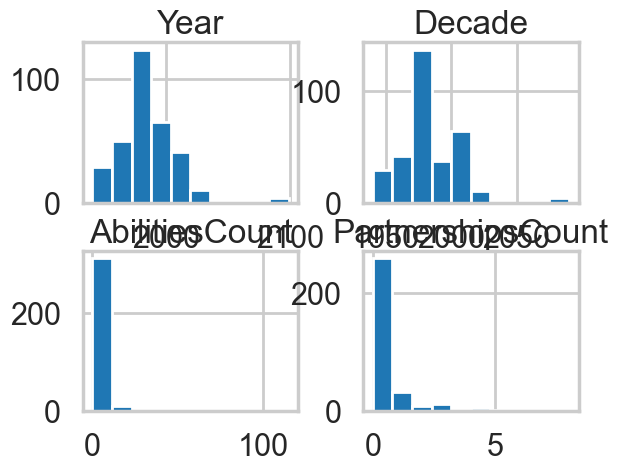

In [38]:
df.hist()

To facilitate reading, histograms can also be based on selected columns.

<Axes: >

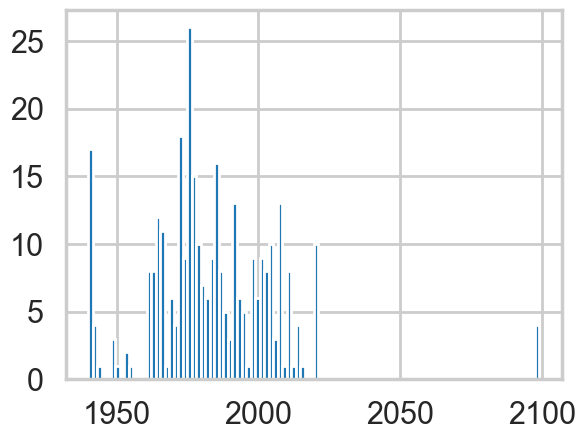

In [39]:
df['Year'].hist(bins=100) # bins determines the number of vertical bars

More complex plots are also possible.

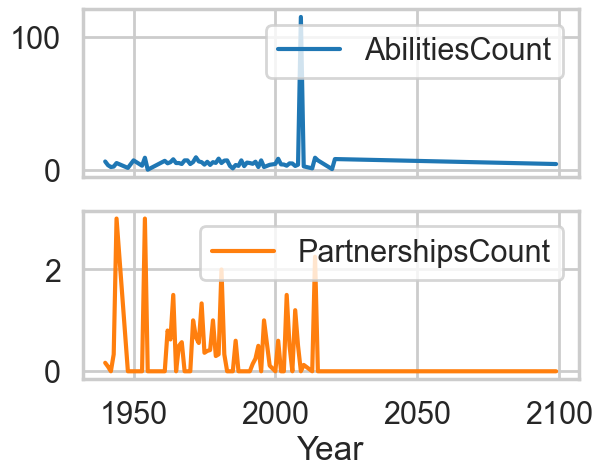

In [40]:
# docs: http://matplotlib.org/api/text_api.html#matplotlib.text.Annotation
#fig = plt.figure()
df[['AbilitiesCount','PartnershipsCount','Year']].groupby("Year").mean().plot(subplots=True)
MaxValue = df['Year'].max()
plt.show()

## Create a Graph from our Data

In the next step, we will create a graph from our data linking the superheroes with their partners and their abilities. Eventually, this will help us to discover which superheroes share abilities.

In [41]:
def createAbilityPartnershipGraphs(consideredDataFrame):
    # for testing purposes it is handy to limit the number of records
    #consideredDataFrame=consideredDataFrame[(consideredDataFrame.Year>=1961) & (consideredDataFrame.Year<1975)]

    # create an empty graph from the nx (networkx) package imported above
    G=nx.Graph()
    G_abilities=nx.Graph()
    
    # DEBUG dictionaries for ID output
    heroIDs=dict()
    heroID=0
    abilityIDs=dict()
    abilityID=0

    # .itertuples() gives us an iterator over all rows in a data frame
    for row in consideredDataFrame.itertuples():
        hero=row[11]
        year=row[2]
        decade=row[3]
        if not hero in heroIDs:
            heroIDs[hero]=heroID
            heroID=heroID+1
            
        if not hero in G.nodes():
            # debug
            #G.add_node(hero)
            # überall wo nun heroNr steht, stand hero
            heroNr=heroIDs[hero]
            G.add_node(heroIDs[hero])
            # the name attribute will be helpful for D3.js visualizations (see below)
            G.nodes[heroNr]['name'] = hero
            G.nodes[heroNr]['year'] = year
            G.nodes[heroNr]['decade'] = decade
            G.nodes[heroNr]['group'] = 2 # will change the display color in D3.js and will be used if a text label has to be plotted for this node
            G.nodes[heroNr]['picture']=row[9]
            localFilePath=str(row[10])
            if not localFilePath.upper()=="NAN":
                G.nodes[heroNr]['localFilePath']=localFilePath
            else:
                G.nodes[heroNr]['localFilePath']="N/A" # must not be left empty, otherwise corrupt JSON will be created below

        if not hero in G_abilities.nodes():
            # debug
            #G_abilities.add_node(hero)
            G_abilities.add_node(heroIDs[hero])
            # überall wo nun heroID steht, stand hero
            heroNr=heroIDs[hero]
            
            G_abilities.nodes[heroNr]['name'] = hero
            G_abilities.nodes[heroNr]['year'] = year
            G_abilities.nodes[heroNr]['decade'] = decade
            G_abilities.nodes[heroNr]['group'] = 2 # will change the display color in D3.js and will be used if a text label has to be plotted for this node
            G_abilities.nodes[heroNr]['picture']=row[9]
            localFilePath=str(row[10])
            if not localFilePath.upper()=="NAN":
                G_abilities.nodes[heroNr]['localFilePath']=localFilePath
            else:
                G_abilities.nodes[heroNr]['localFilePath']="N/A" # must not be left empty, otherwise corrupt JSON will be created below

        # treat partnerships  (PartnershipsCount)  
        if row[7]: # a shortcut to find out whether a string is empty
            if not row[12]=="NAN":
                partners=row[12].split(",")
                for partner in partners:
                    if not partner in G.nodes():
                        G.add_node(partner)
                        G.nodes[partner]['name'] = partner
                        G.nodes[partner]['year'] = year
                        G.nodes[partner]['decade'] = decade
                        G.nodes[partner]['group'] = 2
                    G.add_edge(hero,partner)
                    G[hero][partner]['year'] = year
                    G[hero][partner]['decade'] = decade
                    # this is a tricky part that is only needed for the later visualization of the results with D3.js
                    # during visualization, we want to hide elements of the graph depending on the associated year.
                    # however, ability nodes linked to different hero nodes (and thus years) must not be hidden.
                    # to prevent this, we check for such nodes and give them a dummy year.
                    edgeList=G.edges(partner,data=True)
                    if len(edgeList)>1:
                        for e in edgeList:
                            G.nodes[e[0]]['year'] = "XXX"

        # treat abilities
        if row[5]: #AbilitiesCount
            if not row[13]=="NAN":
                abilities=str(row[13]).split(",")
                for ab in abilities:
                    if not ab in abilityIDs:
                        abilityIDs[ab]=abilityID
                        abilityID=abilityID+1
                        
                    if not ab in G_abilities.nodes():
                        #debug
                        #G_abilities.add_node(ab)
                        G_abilities.add_node(abilityIDs[ab])
                        # überall wo nun abID steht, stand ab
                        abID=abilityIDs[ab]
                        
                        G_abilities.nodes[abID]['name'] = ab
                        G_abilities.nodes[abID]['year'] = year
                        G_abilities.nodes[abID]['decade'] = decade
                        G_abilities.nodes[abID]['group'] = 1 # will change the display color in D3.js
                        #debug
                     
                    #debug 
                    #G_abilities.add_edge(hero,ab)
                    #G_abilities[hero][ab]['year'] = year
                    #G_abilities[hero][ab]['decade'] = decade
                    G_abilities.add_edge(heroIDs[hero],abID)
                    G_abilities[heroIDs[hero]][abID]['year'] = year
                    G_abilities[heroIDs[hero]][abID]['decade'] = decade
                    # this is a tricky part that is only needed for the later visualization of the results with D3.js
                    # during visualization, we want to hide elements of the graph depending on the associated year.
                    # however, ability nodes linked to different hero nodes (and thus years) must not be hidden.
                    # to prevent this, we check for such nodes and give them a dummy year.
                    #debug
                    #edgeList=G_abilities.edges(ab,data=True)
                    edgeList=G_abilities.edges(abID,data=True)
                    if len(edgeList)>1:
                        for e in edgeList:
                            G_abilities.nodes[e[0]]['year'] = "XXX"
                    print("Adding edge: "+hero+" - "+str(ab))
                #G_abilities.add_edges_from(list(itertools.product(abilities,abilities))) # macht ein cross product der abilities
    return [G,G_abilities]

# DEBUG
#r=createAbilityPartnershipGraphs(df.head(30))
r=createAbilityPartnershipGraphs(df)

G=r[0]
G_abilities=r[1]

print("Statistics of the superhero partnership graph.")
print(G.number_of_nodes())
print(G.number_of_edges())

print("\nStatistics of the superhero ability graph.")
print(G_abilities.number_of_nodes())
print(G_abilities.number_of_edges())

Adding edge: ABOMINATION - SUPERHUMAN STRENGTH
Adding edge: ABOMINATION -  STAMINA
Adding edge: ABOMINATION -  DURABILITY
Adding edge: ABOMINATION -  SPEED
Adding edge: ABOMINATION -  AND SENSES
Adding edge: ABOMINATION - REGENERATION
Adding edge: ABOMINATION - UNDERWATER BREATHING
Adding edge: ABOMINATION - GAMMA ENERGY CONTROL
Adding edge: AGENT X - SUPERHUMAN STRENGTH
Adding edge: AGENT X -  STAMINA
Adding edge: AGENT X -  AGILITY
Adding edge: AGENT X -  SPEED
Adding edge: AGENT X -  AND REFLEXES
Adding edge: AGENT X - REGENERATIVE HEALING FACTOR
Adding edge: AGENT X - TELEPATHIC IMMUNITY
Adding edge: AGENT X - DISEASE IMMUNITY
Adding edge: AGENT X - LONGEVITY
Adding edge: AGENT X - EXPERT MARKSMAN
Adding edge: GABRIEL LANAIR-WALKER - POWER COSMIC
Adding edge: AJAK - SUPERHUMAN SPEED
Adding edge: AJAK -  STRENGTH
Adding edge: AJAK -  AND DURABILITY
Adding edge: AJAK - COSMIC ENERGY MANIPULATION
Adding edge: AJAK - ACCELERATED HEALING FACTOR
Adding edge: AJAK - NEAR-IMMORTALITY
Addin

## Using the Data in Your Website

If you want to display the data on an interactive website for a wider audience, Jupyter notebooks might no longer be appropriate. Fortunately, the networkx package allows us to export the graph data as JSON files which can be easily read by JavaScript.

In [42]:
import json
from networkx.readwrite import json_graph

# create needed subdirectories
if not os.path.exists('./web/force/'):
    os.mkdir('./web/force/')
if not os.path.exists('./web/force/'+pathPrefix+"/"):
    os.mkdir('./web/force/'+pathPrefix+"/")

#d = json_graph.node_link_data(G)
d = json_graph.node_link_data(G_abilities)

    
jsonPath='./web/force/'+pathPrefix+'/force.json'
json.dump(d, open(jsonPath,'w'))

printLog("Saved JSON file to: "+jsonPath)
# weitere notwendige Files für D3.js visualization unter: /Users/david/Documents/src/javascript/visualization
# examples taken from https://github.com/networkx/networkx/tree/master/examples/javascript

[2026-01-20 14:01:36.247484]	Saved JSON file to: ./web/force/marvel/force.json


As graphs can be become to large to be displayed responsively, we will also export the data separated by decades.

In [43]:
decades=[1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020]
dataframes=OrderedDict()
for decade in decades:
    dfTemp=df[(df.Decade==decade)]
    dataframes[decade]=dfTemp

In [44]:
df[df.Decade==2020].describe()

,Year,Decade,AbilitiesCount,PartnershipsCount
count,10.000000,10.0,10.000000,10.0
mean,2020.100000,2020.0,1.200000,0.0
std,0.316228,0.0,2.529822,0.0
min,2020.000000,2020.0,0.000000,0.0
25%,2020.000000,2020.0,0.000000,0.0
50%,2020.000000,2020.0,0.000000,0.0
75%,2020.000000,2020.0,1.500000,0.0
max,2021.000000,2020.0,8.000000,0.0


In [45]:
groupedStats=df[['AbilitiesCount','PartnershipsCount',"Decade"]].groupby("Decade").count()
groupedStats.to_csv("./web/force/"+pathPrefix+"/decadeStats.csv")

In [46]:
for decade in dataframes:
    currentDF=dataframes[decade]
    r=createAbilityPartnershipGraphs(currentDF)
    d = json_graph.node_link_data(r[1])
    jsonPath='./web/force/'+pathPrefix+"/"+str(decade)+'.json'
    json.dump(d, open(jsonPath,'w'))

    printLog("Saved JSON file to: "+jsonPath)

[2026-01-20 14:01:41.763669]	Saved JSON file to: ./web/force/marvel/1900.json
[2026-01-20 14:01:41.766771]	Saved JSON file to: ./web/force/marvel/1910.json
[2026-01-20 14:01:41.768807]	Saved JSON file to: ./web/force/marvel/1920.json
[2026-01-20 14:01:41.770406]	Saved JSON file to: ./web/force/marvel/1930.json
Adding edge: BLACK MARVEL - EXCELLENT HAND TO HAND COMBATANT
Adding edge: BLACK MARVEL - PEAK PHYSICAL CONDITION
Adding edge: THE BLACK RIDER - SKILLED HORSEMAN
Adding edge: THE BLACK RIDER - MARKSMAN
Adding edge: BLAZING SKULL - SUPERHUMAN STRENGTH
Adding edge: BLAZING SKULL - IMMUNITY TO FIRE
Adding edge: BLAZING SKULL - REGENERATIVE HEALING FACTOR
Adding edge: BLAZING SKULL - FLAME GENERATION
Adding edge: BLAZING SKULL - PROJECTION
Adding edge: BLAZING SKULL - ABILITY TO MAKE HIS TISSUES INVISIBLE WHILE LEAVING HIS BONES VISIBLE
Adding edge: THE BLUE DIAMOND - SUPERHUMAN STRENGTH
Adding edge: THE BLUE DIAMOND - NIGH-INVULNERABILITY
Adding edge: THE BLUE DIAMOND - DIAMOND HARD 

## Displaying the Results

Now we are set to display the results in a browser. However, to prevent security warnings, we cannot directly open the HTML files saved in the web/ directory. Hence, we launch a built-in Python webserver for display.

If you see a more or less emptpy page, please click "All".

_ATTENTION_ Never interrupt the kernel after you have started the following cell. Just press <ENTER> in the input field displayed in the cell below.

If you have accidently interrupted the kernel, Python will not release the listener on port 8000. Thus, you will not be able to re-run the following cell. To solve the problem, you must restart the whole Jupyter notebook process.

In [48]:
# if you make changes to http_server.py you will have to delete http_server.pyc manually
import http_server
if isMarvel:
    http_server.load_url('./web/force/force_marvel.html')
else:
    http_server.load_url('./web/force/force_dc.html')

Webserver working directory: /Users/david/src/CulturalAnalytics


127.0.0.1 - - [20/Jan/2026 14:15:53] "GET /web/force/force_marvel.html HTTP/1.1" 304 -
127.0.0.1 - - [20/Jan/2026 14:15:53] "GET /web/force/barchart.js HTTP/1.1" 304 -
127.0.0.1 - - [20/Jan/2026 14:15:53] "GET /web/css/sbbbrowse.css HTTP/1.1" 304 -
127.0.0.1 - - [20/Jan/2026 14:15:53] "GET /web/force/force.js HTTP/1.1" 304 -
127.0.0.1 - - [20/Jan/2026 14:15:53] "GET /web/force/marvel/force.json HTTP/1.1" 304 -
127.0.0.1 - - [20/Jan/2026 14:15:53] "GET /web/force/marvel/decadeStats.csv HTTP/1.1" 304 -
127.0.0.1 - - [20/Jan/2026 14:15:55] code 404, message File not found
127.0.0.1 - - [20/Jan/2026 14:15:55] "GET /web/force/img.marvel_chars/178.jpg HTTP/1.1" 404 -
127.0.0.1 - - [20/Jan/2026 14:15:55] code 404, message File not found
127.0.0.1 - - [20/Jan/2026 14:15:55] "GET /web/force/img.marvel_chars/549.png HTTP/1.1" 404 -
127.0.0.1 - - [20/Jan/2026 14:15:55] code 404, message File not found
127.0.0.1 - - [20/Jan/2026 14:15:55] "GET /web/force/img.marvel_chars/483.jpg HTTP/1.1" 404 -
12

Press <RETURN> to stop server
 


To restart server run: 
python -m http.server 8000


# Potential improvements

* comparison of DC and Marvel characters on one page
* sentiment analysis on abilities etc.
* sentiment analysis of the associated wikipedia article
* correlations between super heroes and abilities or the like (lone super heroues with negative articles on wikipedia?)